In [22]:
!pip install jovian --upgrade --quiet

     |████████████████████████████████| 71kB 7.2MB/s 


In [23]:
import jovian

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
%matplotlib inline

In [3]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
data_dir = './gdrive/MyDrive/dataset_intel/' # Path to dataset

print(os.listdir(data_dir)) # Print folders in dataset
classes = os.listdir(data_dir + '/seg_train/seg_train') # Image Classes
print(classes)

['.ipynb_checkpoints', 'seg_pred', 'seg_train', 'seg_test']
['mountain', 'glacier', 'sea', 'buildings', 'forest', 'street']


We can see there are 6 different categories. Now, we will find out how many images are un every category. We will make a bar plot as well.

In [5]:
count = []
for folder in classes:
    num_images = len(os.listdir(data_dir + '/seg_train/seg_train/' + folder))
    count.append(num_images)
    print(f'There are {num_images} images in the {folder} category.')

There are 2512 images in the mountain category.
There are 2404 images in the glacier category.
There are 2274 images in the sea category.
There are 2191 images in the buildings category.
There are 2281 images in the forest category.
There are 2382 images in the street category.


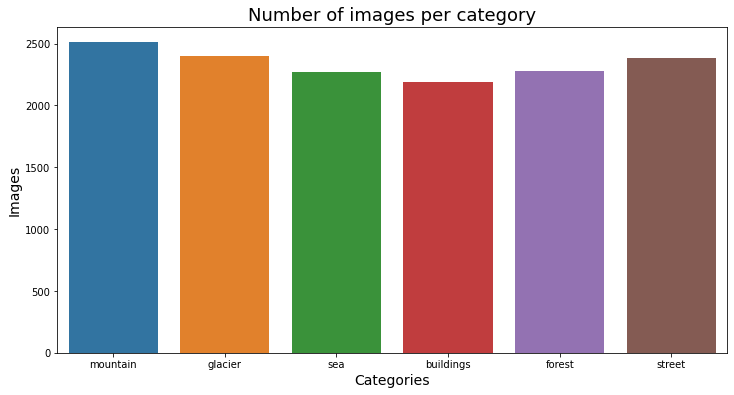

In [6]:
plt.figure(figsize=(12, 6))
sns.barplot(x=classes, y=count)
plt.title('Number of images per category', size=18)
plt.ylabel('Images', size=14)
plt.xlabel('Categories', size=14)
plt.show;

We observe the number of images in each class is different, but on average it is around 2200 images per class. Now we will create the tensor dataset.

Not all images have the same size, so we need to resize all the images. I will use a size of 128x128 pixels. I will apply some transforms to avoid overfitting in the future.

In [7]:
# Data transforms (normalization & data augmentation)
stats = ((0.4300, 0.4571, 0.4533), (0.2581, 0.2563, 0.2886))
train_tfms = tt.Compose([tt.Resize((128, 128)),
                         tt.RandomCrop(128, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.Resize((128, 128)), tt.ToTensor(), tt.Normalize(*stats)])

In [9]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/seg_train/seg_train/', train_tfms)
test_ds = ImageFolder(data_dir+'/seg_test/seg_test/', valid_tfms)

In [11]:
#Now, we will show some images from the dataset to have an idea of its level of complexity.
def show_example(img, label):
    print(f'Label: {train_ds.classes[label]} ({label})')
    print(f'image.shape: {img.shape}')
    plt.imshow(img.permute(1, 2, 0))

With this function, we can show the images very easily. Let's see some examples.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: buildings (0)
image.shape: torch.Size([3, 128, 128])


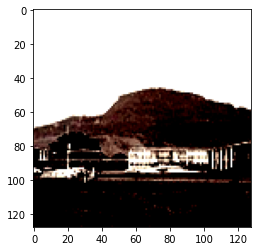

In [12]:
show_example(*train_ds[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: glacier (2)
image.shape: torch.Size([3, 128, 128])


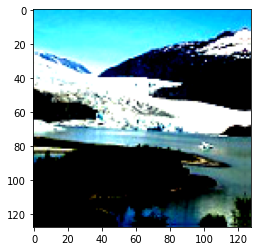

In [13]:
show_example(*train_ds[5262])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: buildings (0)
image.shape: torch.Size([3, 128, 128])


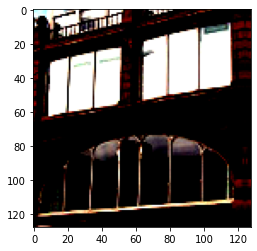

In [14]:
show_example(*train_ds[11])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: buildings (0)
image.shape: torch.Size([3, 128, 128])


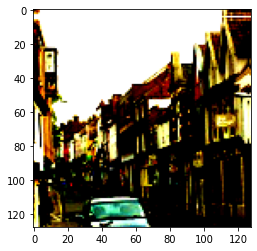

In [15]:
show_example(*train_ds[900])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: buildings (0)
image.shape: torch.Size([3, 128, 128])


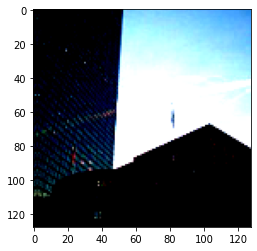

In [16]:
show_example(*train_ds[13])

After seeing some examples, we can tell the dataset is quite challenging, becauase the images are very different. For example, in the first example, it has the label "buildings", but there is a mountain right behind de building, so it makes it a little tricky. Also, there are some grayscale images and color images, which also makes it a little harder. We can also see some of the transforms I apllied.

Now, we have to create Data Loaders

In [17]:
batch_size = 32

In [18]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

We have separated the images in batches to make training faster and to use less RAM. Let's take a look at the first batch.

In [19]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(20, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


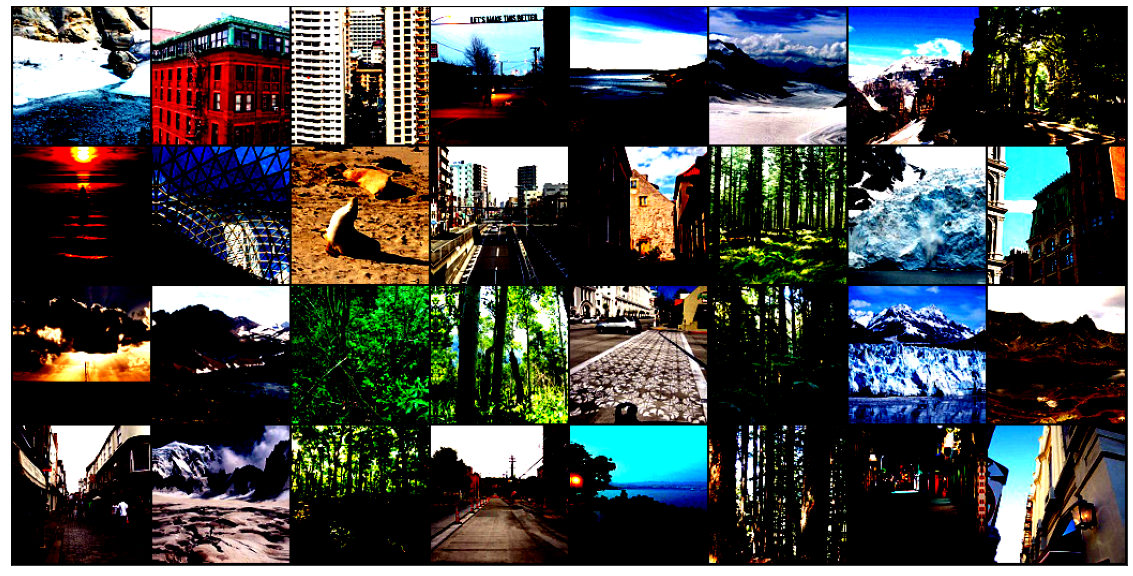

In [20]:
show_batch(train_dl)

**Modeling**

Now we will create a base class for our model.

In [26]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [27]:
#Now we will use the base class to build the model architecture. We will use the ResNet9 architecture

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]

    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 254, pool=True)
        self.conv4 = conv_block(254, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512*4*4, num_classes)) # 512 x 4 x 4

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [28]:
#Now we create the model
model = ResNet9(3, 10)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [29]:
# We will move everything to a GPU to make the training faster.

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [30]:
device = get_default_device()
device

device(type='cuda')

In [31]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(model, device);

In [32]:
# Now, we need to train the model. We will define some functions for that.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Now, we will train the model. We'll try to reach at least 90% accuracy, but first let's calculate the loss and accuracy of the model.

In [33]:
history = [evaluate(model, test_dl)]
history

[{'val_acc': 0.16921542584896088, 'val_loss': 2.302929401397705}]

We can see the accuracy is around 1%, which is reasonable because at the moment we have not performed any training. Now it's time to train the model.

In [34]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [35]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, test_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00395, train_loss: 1.4659, val_loss: 1.9681, val_acc: 0.6230
Epoch [1], last_lr: 0.00936, train_loss: 1.3910, val_loss: 0.6892, val_acc: 0.7482
Epoch [2], last_lr: 0.00972, train_loss: 0.6534, val_loss: 0.6667, val_acc: 0.7637
Epoch [3], last_lr: 0.00812, train_loss: 0.5629, val_loss: 0.5092, val_acc: 0.8267
Epoch [4], last_lr: 0.00556, train_loss: 0.5029, val_loss: 0.5608, val_acc: 0.8090
Epoch [5], last_lr: 0.00283, train_loss: 0.4627, val_loss: 0.4236, val_acc: 0.8517
Epoch [6], last_lr: 0.00077, train_loss: 0.3914, val_loss: 0.3598, val_acc: 0.8803
Epoch [7], last_lr: 0.00000, train_loss: 0.3170, val_loss: 0.3271, val_acc: 0.8862
CPU times: user 3min 58s, sys: 2min 42s, total: 6min 41s
Wall time: 32min 47s


In [36]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, test_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00395, train_loss: 0.4331, val_loss: 0.4314, val_acc: 0.8572
Epoch [1], last_lr: 0.00936, train_loss: 0.6027, val_loss: 0.6693, val_acc: 0.7564
Epoch [2], last_lr: 0.00972, train_loss: 0.6287, val_loss: 0.6484, val_acc: 0.7815
Epoch [3], last_lr: 0.00812, train_loss: 0.5822, val_loss: 0.5905, val_acc: 0.7789
Epoch [4], last_lr: 0.00556, train_loss: 0.4913, val_loss: 0.4618, val_acc: 0.8451
Epoch [5], last_lr: 0.00283, train_loss: 0.4238, val_loss: 0.3827, val_acc: 0.8640
Epoch [6], last_lr: 0.00077, train_loss: 0.3595, val_loss: 0.3332, val_acc: 0.8849
Epoch [7], last_lr: 0.00000, train_loss: 0.3186, val_loss: 0.3188, val_acc: 0.8889
CPU times: user 4min 14s, sys: 2min 53s, total: 7min 7s
Wall time: 8min 19s


In [37]:
epochs = 16
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [38]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, test_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00139, train_loss: 0.3213, val_loss: 0.3563, val_acc: 0.8857
Epoch [1], last_lr: 0.00395, train_loss: 0.3702, val_loss: 0.3736, val_acc: 0.8758
Epoch [2], last_lr: 0.00703, train_loss: 0.4878, val_loss: 0.4549, val_acc: 0.8471
Epoch [3], last_lr: 0.00936, train_loss: 0.5185, val_loss: 1.4904, val_acc: 0.7308
Epoch [4], last_lr: 0.00999, train_loss: 0.4915, val_loss: 0.8066, val_acc: 0.7592
Epoch [5], last_lr: 0.00972, train_loss: 0.5036, val_loss: 0.6388, val_acc: 0.7842
Epoch [6], last_lr: 0.00908, train_loss: 0.4705, val_loss: 0.4448, val_acc: 0.8397
Epoch [7], last_lr: 0.00812, train_loss: 0.4625, val_loss: 0.4727, val_acc: 0.8316
Epoch [8], last_lr: 0.00691, train_loss: 0.4500, val_loss: 0.4171, val_acc: 0.8553
Epoch [9], last_lr: 0.00556, train_loss: 0.4128, val_loss: 0.3805, val_acc: 0.8749
Epoch [10], last_lr: 0.00416, train_loss: 0.3825, val_loss: 0.6566, val_acc: 0.8457
Epoch [11], last_lr: 0.00283, train_loss: 0.3694, val_loss: 0.3303, val_acc: 0.8867
Ep

In [39]:
epochs = 5
max_lr = 0.004
grad_clip = 0.04
weight_decay = 1e-5
opt_func = torch.optim.Adam

In [40]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, test_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00304, train_loss: 0.3017, val_loss: 0.3549, val_acc: 0.8831
Epoch [1], last_lr: 0.00380, train_loss: 0.3538, val_loss: 0.4031, val_acc: 0.8615
Epoch [2], last_lr: 0.00245, train_loss: 0.3356, val_loss: 0.3325, val_acc: 0.8864
Epoch [3], last_lr: 0.00075, train_loss: 0.3049, val_loss: 0.3094, val_acc: 0.8922
Epoch [4], last_lr: 0.00000, train_loss: 0.2754, val_loss: 0.3049, val_acc: 0.8962
CPU times: user 2min 39s, sys: 1min 49s, total: 4min 29s
Wall time: 5min 13s


In [41]:
import random

In [42]:
def denormalize(images, mean, std):
    invTrans = tt.Compose([ tt.Normalize(mean=[ 0., 0., 0. ],
                                                     std = [ 1/std[0], 1/std[1], 1/std[2] ]),
                                tt.Normalize(mean = [-1*mean[0], -1*mean[2], -1*mean[2] ],
                                                     std = [ 1., 1., 1. ]),
                               ])
    return invTrans(images)

In [43]:
def predict_image(img, label):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, pred = torch.max(yb, dim=1)
    print(f'Label: {train_ds.classes[label]}, Predicted: {train_ds.classes[pred]}')
    img = denormalize(img, *stats)
    plt.imshow(img.permute(1, 2, 0))

Label: buildings, Predicted: buildings


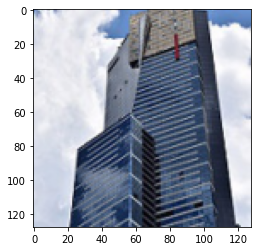

In [44]:
predict_image(*test_ds[0])


Label: glacier, Predicted: glacier


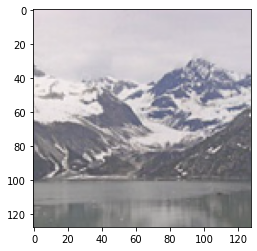

In [45]:
predict_image(*test_ds[1429])


Label: street, Predicted: buildings


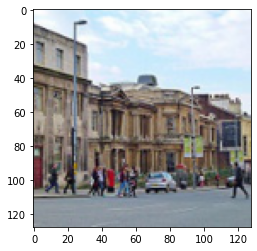

In [46]:
predict_image(*test_ds[random.randint(2000, 3000)])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: buildings, Predicted: buildings


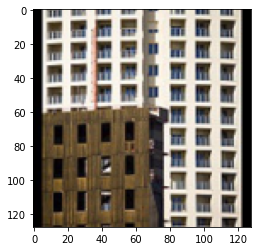

In [47]:
predict_image(*test_ds[random.randint(0, 3000)])


Label: street, Predicted: street


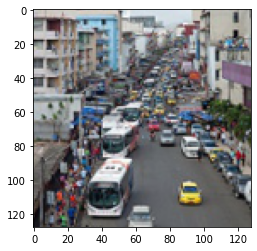

In [48]:
predict_image(*test_ds[random.randint(0, 3000)])


Label: forest, Predicted: forest


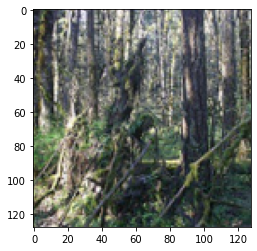

In [49]:
predict_image(*test_ds[random.randint(0, 3000)])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: sea, Predicted: sea


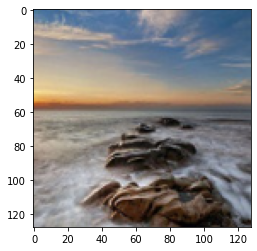

In [50]:
predict_image(*test_ds[random.randint(0, 3000)])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: glacier, Predicted: glacier


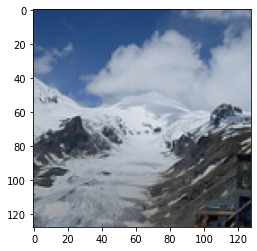

In [51]:
predict_image(*test_ds[random.randint(0, 3000)])


In [53]:
evaluate(model, test_dl)

{'val_acc': 0.896229088306427, 'val_loss': 0.3049356937408447}

In [54]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

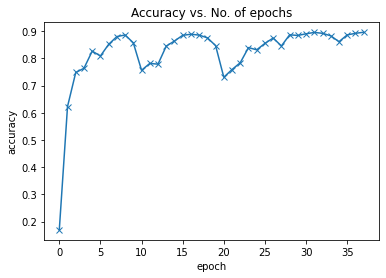

In [55]:
plot_accuracies(history)


In [56]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

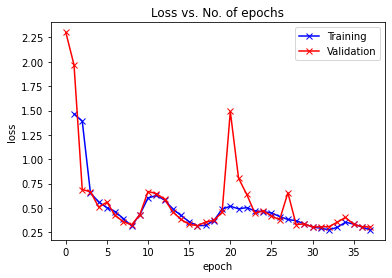

In [57]:
plot_losses(history)


It seems overfitting has not happened. That's good news!

Now we will record the metrics and hyperparameters with Jovian.

In [58]:
jovian.log_hyperparams({
    'num_epochs': 37,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
})

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Hyperparams logged.


In [59]:
jovian.log_metrics(train_loss=history[-1]['train_loss'], 
                   val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'])

[jovian] Metrics logged.


In [62]:
torch.save(model.state_dict(), 'places-model2.pth')


In [63]:
project_name = 'course-project-zerotogans'
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...


[jovian] Error: Colab File Id is not provided. Make sure to execute the cell where the Id is set.
